In [1]:
from expl_bind_vertex_calc import *
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

# ARC, only including points where $\sum \phi = 1$

In [3]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
e_m = np.array([2, 2]) #binding energy FOR F_BIND_ALT


v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.6
phi_s = 0.1
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]


v_s = 1
v_p = 1
v_A = v_p
v_B = v_p
N_P = 5000
N_A = 50
N_B = N_A
b_P = 1
b_A = b_P
b_B = b_P

chi_AB = 100/(N_P*phi_p)

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, phi_s, \
                    poly_marks, v_s, v_p, v_A, v_B, N_P, N_A, N_B,
                    b_P, b_A, b_B, chi_AB)


# klog_min = -2.5
# klog_max = -.1
# klog_num = 30

klog_min = -2.5
klog_max = -1.69 # = np.log10(1/N_A)
klog_num = 10

k_vec = np.logspace(klog_min, klog_max, klog_num) / b_P

In [4]:
%%time
phi_Au_arr = np.arange(0.001, 1 - phi_p - phi_s, 0.01)
phi_Bu_arr = phi_Au_arr

muA_valid, muB_valid, sA_valid, sB_valid, \
fA_valid, fB_valid, phi_Au_valid, phi_Bu_valid, phi_Ab_valid,\
phi_Bb_valid = calc_mu_phi_bind_filter(psol, phi_Au_arr, phi_Bu_arr)

CPU times: total: 203 ms
Wall time: 197 ms


## spinodal

In [6]:
%%time
# chi_AP = 0
# chi_BP = 0
# # chi_AB = 69.5 / (phi_p*N_P) 
# chi_PS = 0
# chi_AS = 0
# chi_BS = 0

# chis = [chi_AP, chi_BP, chi_AB, chi_PS, chi_AS, chi_BS]


min_eigval_arr = np.zeros((len(phi_Au_valid), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros(len(phi_Au_valid))
min_eigval_arr_allk_ps = np.zeros(len(phi_Au_valid))

# min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 5))
# min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 5))
min_eigvec_arr = np.zeros((len(phi_Au_valid), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_valid), 3))
k_star_arr_DENS= np.zeros(len(phi_Au_valid))

cond_num_arr = np.zeros((len(phi_Au_valid), len(k_vec)))
max_cond_arr = np.zeros(len(phi_Au_valid))

for i in range(len(phi_Au_valid)):
#         if mu1 == mu2:
#             continue
        # mu = [mu1, mu2]
        # print("mu: ", mu)
        s_bnd_A = sA_valid[i]
        s_bnd_B = sB_valid[i]

        phi_Au = phi_Au_valid[i]
        phi_Bu = phi_Bu_valid[i]

        phius = [phi_Au, phi_Bu]
        # if i == 0 and j == len(phi_Au_arr)-1:
        #     print("SA: ", s_bnd_A)
        #     print("SB: ", s_bnd_B)
        for ik, k in enumerate(k_vec):

            # print(k)

            # s_bnd_A = s_bind_A_ALL[i, j]
            # s_bnd_B = s_bind_B_ALL[i, j]

            # M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            # S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            # cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, phius, k)

            
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            # print(val)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][ik] = min_val
            min_eigvec_arr[i][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][:][np.nonzero(min_eigval_arr[i][:])] 
        min_vecs = min_eigvec_arr[i][:][np.nonzero(min_eigval_arr[i][:])]

        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i] = minval_allk 
        min_eigvec_arr_allk_DENS[i] = min_vecs[np.where(min_vals==minval_allk)]

        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i] = k_star

        # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

CPU times: total: 359 ms
Wall time: 471 ms


In [7]:
spinodal = np.copy(k_star_arr_DENS)
spinodal[np.where(spinodal == k_vec[0])] = 0 # macro
spinodal[np.where(spinodal > k_vec[0])] = 1 # micro

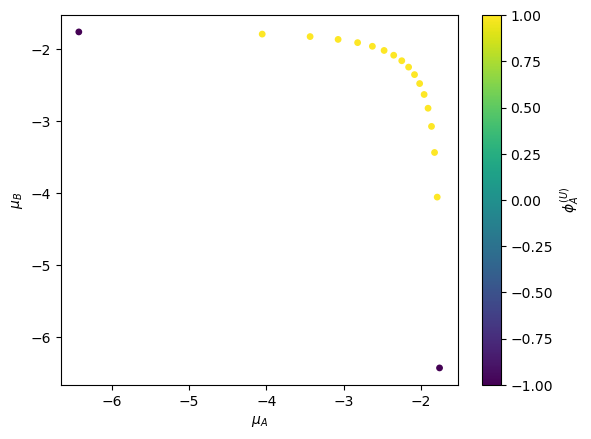

In [8]:
plt.scatter(muA_valid, muB_valid, c=spinodal, s=15, cmap='viridis')
plt.xlabel(r'$\mu_A$'); plt.ylabel(r'$\mu_B$')
plt.colorbar(label=r'$\phi_A^{(U)}$')

## phases

In [ ]:
# %%time

# mu1_i = 5
# mu2_i = 6
# mu1_array[mu1_i]
# chi = 0
# chis = [chi_AB, chi_AS]
# mu1_i_min = 5
# mu1_i_max = 15
# mu2_i_min = 5
# mu2_i_max = 15
# phases = np.zeros((len(mu1_array[mu1_i_min:mu1_i_max]), len(mu2_array[mu2_i_min:mu2_i_max]))) - 1 
# minF_arr = np.zeros((len(mu1_array[mu1_i_min:mu1_i_max]), len(mu2_array[mu2_i_min:mu2_i_max]))) 

# mu1_i = 0
# mu2_j = 6

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal
# k_star_arr_DENS[np.where(k_star_arr_DENS == k_vec[0]) ] = -1 # unphysical value, to indicate macrophase separation


phases = np.zeros(len(phi_Au_valid)) - 1 
minF_arr = np.zeros_like(phases) 
for i in range(len(phi_Au_valid)):
    # if i != mu1_i:
    #     continue
    # if j != mu2_j:
    #     continue

    # print("mu: ", mu1, mu2)
    q_star = k_star_arr_DENS[i]
    vec_star = min_eigvec_arr_allk_DENS[i]

    
    if q_star == -1:
        print("out of spinodal; no q_star")
        phases[i] = 0 # disordered phase- outside of spinodal
    elif q_star == k_vec[0]:
    # elif q_star != k_vec[-1]:
        print("macrophase sep")
        phases[i] = 1 # macrophase sep

    else: #microphse sep
    
        s_bnd_A = sA_valid[i,:]#s_bind_A_ALL[i,j,:]
        s_bnd_B = sB_valid[i,:]#s_bind_B_ALL[i,j,:]

        pihus = [phi_Au, phi_Bu]
        lam_q = q_star*np.array([1, 0, 0])
        lam_q = np.linalg.norm(lam_q)

        cyl_q1 = q_star*np.array([1, 0, 0])
        # cyl_q1 = np.linalg.norm(cyl_q1)
        cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
        # cyl_q2 = np.linalg.norm(cyl_q2)
        cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
        # cyl_q3 = np.linalg.norm(cyl_q3)
        cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
        
        bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
        bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
        bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
        bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
        bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
        bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
        
        
        lam_g3 = 0
        G3 = gamma3(psol, s_bnd_A, s_bnd_B, phius, cyl_qs) # all g3s are eqivlaent
        cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
        bcc_g3 = (4/(3*np.sqrt(6))) * G3
        
        G4_00 = gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([lam_q, -lam_q, lam_q, -lam_q]))
        lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
        
        cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
          72*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
        
        bcc_g4 = (1/24)* (G4_00 \
                 + 8*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
                 + 2*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
                 + 4*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )

        lam_g2 = (1/2) * 2 * (1) * gamma2_chis(psol, s_bnd_A, s_bnd_B, phius, q_star)
        cyl_g2 = lam_g2
        bcc_g2 = lam_g2

        # # # PHYSICALLY BOUNDED AMPLITUDE
        # # del_phi = phi - phi_0. phi goes from 0 to phi_p. therefore del_phi(max) = phi_p-phi_0 ; del_phi(min) = - phi_0
        # # need to use a sigmoid (goes 0 to 1) then del_phi = phi_p * sigmoid(amps) - phi_0 ; phi_0 = [f_O, f_A, f_B]
        # # raise Exception("NNED to implement phi right----- look below :D")
        # phi_0 = phi_p * np.array([fo_mat[0][0], fa_mat[0][0], fb_mat[0][0]])
        # initial = [0, 0, 0] # poly, A, B
        # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
        #                                                 phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
        # lamF_q = res.fun
        
        # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
        #                                    #  + np.einsum("ijk,i,j,k ->", cyl_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
        #                                    # +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
        #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
        # cylF_q = 1000000000#res.fun

        # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
        #                                    #  + np.einsum("ijk,i,j,k ->", bcc_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
        #                                    # +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
        #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
        # bccF_q = 1000000000#res.fun          




        print("made it to crit fluc")            
        # CRITICAL FLUCTIATION
        # define a lambda scalar value for a given critica lfluctutaion, then use roots equation to find cirtical points, and eval F at each
        lam_lambda_2 = np.einsum("ij,i,j ->", lam_g2, vec_star, vec_star)
        lam_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -lam_g4, vec_star, vec_star, vec_star, vec_star)

        pos_l_amps = np.real(np.roots([4*lam_lambda_4,0,2*lam_lambda_2,0]))        
        lamF = min(np.real( lam_lambda_2 * pos_l_amps**2 + lam_lambda_4 * pos_l_amps**4))

        
        cyl_lambda_2 = np.einsum("ij,i,j ->", cyl_g2, vec_star, vec_star)
        cyl_lambda_3 = np.einsum("ijk,i,j,k->", cyl_g3, vec_star, vec_star, vec_star)
        cyl_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -cyl_g4, vec_star, vec_star, vec_star, vec_star)

        pos_c_amps = np.real(np.roots([4*cyl_lambda_4,3*cyl_lambda_3,2*cyl_lambda_2,0]))        
        cylF = min(np.real( cyl_lambda_2 * pos_c_amps**2 + cyl_lambda_3*pos_c_amps**3 + cyl_lambda_4 * pos_c_amps**4))

        
        bcc_lambda_2 = np.einsum("ij,i,j ->", bcc_g2, vec_star, vec_star)
        bcc_lambda_3 = np.einsum("ijk,i,j,k->", bcc_g3, vec_star, vec_star, vec_star)
        bcc_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -bcc_g4, vec_star, vec_star, vec_star, vec_star)

        pos_b_amps = np.real(np.roots([4*bcc_lambda_4,3*bcc_lambda_3,2*bcc_lambda_2,0]))        
        bccF = min(np.real( bcc_lambda_2 * pos_b_amps**2 + bcc_lambda_3*pos_b_amps**3 + bcc_lambda_4 * pos_b_amps**4))        


        

        # # # BASINHOPPING UNRESTRICTED works at low chi
    
        # initial = [0, 0, 0] # poly, A, B
        # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, amps, amps, amps, amps)), initial)
        # lamF_q = res.fun
        # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
        #                                     + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4, amps, amps, amps, amps)), initial)
        # cylF_q = res.fun

        # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
        #                                     + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4, amps, amps, amps, amps)), initial)
        # bccF_q = res.fun            


        
        minF = np.min([lamF, cylF, bccF, 0])
        minF_arr[i] = minF
        # print("--------------------------------------------------------------------")
        # print("energies:")
        print([lamF, cylF, bccF, 0])
        # print("--------------------------------------------------------------------")

        # # print([lamF])
        # # print([lamF, cylF])#, bccF])
        if minF == 0:
            # raise Exception("phase sep not stable in spinodal??")
            phases[i] = -2
        elif minF == lamF:
            phases[i] = 2
        elif minF == cylF:
            phases[i] = 3
        elif minF == bccF:
            phases[i] = 4

    np.save("expl_bind_minF_valid_em="+str(e_m[0]), minF_arr)
    np.save("expl_bind_phases_valid_em="+str(e_m[0]), phases)
        

out of spinodal; no q_star


In [ ]:
plt.scatter(muA_valid, muB_valid, c=phases, s=15, cmap='viridis')
plt.xlabel(r'$\mu_A$'); plt.ylabel(r'$\mu_B$')
plt.colorbar(label=r'$\phi_A^{(U)}$')

# GRID, including invalid points

In [13]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
e_m = np.array([2, 2]) #binding energy FOR F_BIND_ALT


v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.6
phi_s = 0.1
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]


v_s = 1
v_p = 1
v_A = v_p
v_B = v_p
N_P = 5000
N_A = 50
N_B = N_A
b_P = 1
b_A = b_P
b_B = b_P

chi_AB = 100/(N_P*phi_p)

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, phi_s, \
                    poly_marks, v_s, v_p, v_A, v_B, N_P, N_A, N_B,
                    b_P, b_A, b_B, chi_AB)


# klog_min = -2.5
# klog_max = -.1
# klog_num = 30

klog_min = -2.5
klog_max = -1.69 # = np.log10(1/N_A)
klog_num = 10

k_vec = np.logspace(klog_min, klog_max, klog_num) / b_P

In [15]:
k_vec

array([0.00316228, 0.00389045, 0.0047863 , 0.00588844, 0.00724436,
       0.00891251, 0.01096478, 0.01348963, 0.01659587, 0.02041738])

In [17]:
1/(N_P/M) # What the maximum wavevector should be (minimum lengthscale where microphassse separation can occur

1/N_A # What the maximum wavevector should be (minimum lengthscale where microphassse separation can occur

0.02

In [19]:
np.log10(1/N_A) 

-1.6989700043360187

In [21]:
phi_Au_arr = np.arange(0.001, 0.07, 0.01)
# phi_Au_arr = np.arange(0.001, 0.1, 0.01)

phi_Bu_arr = phi_Au_arr

muA_mat, muB_mat, sA_mat, sB_mat, \
fA_mat, fB_mat, phi_Au_mat, phi_Bu_mat, phi_Ab_mat,\
phi_Bb_mat = calc_mu_phi_bind(psol, phi_Au_arr, phi_Bu_arr)

phi_tot =  0.704495779594649
phi_tot =  0.726284943040599
phi_tot =  0.747018333992745
phi_tot =  0.7668441188407721
phi_tot =  0.7858826343387925
phi_tot =  0.8042328201762989
phi_tot =  0.8219769119208759
phi_tot =  0.726284943040599
phi_tot =  0.7473450533117791
phi_tot =  0.7674293621627837
phi_tot =  0.786673269382395
phi_tot =  0.805186985329993
phi_tot =  0.8230613039527835
phi_tot =  0.8403718265920523
phi_tot =  0.747018333992745
phi_tot =  0.7674293621627837
phi_tot =  0.786934869467315
phi_tot =  0.8056591365388865
phi_tot =  0.8237035372914265
phi_tot =  0.8411517453793342
phi_tot =  0.8580735540421734
phi_tot =  0.7668441188407721
phi_tot =  0.786673269382395
phi_tot =  0.8056591365388865
phi_tot =  0.8239162388773672
phi_tot =  0.8415381781040194
phi_tot =  0.8586023547870095
phi_tot =  0.8751734374751131
phi_tot =  0.7858826343387925
phi_tot =  0.805186985329993
phi_tot =  0.8237035372914265
phi_tot =  0.8415381781040194
phi_tot =  0.8587776258057381
phi_tot =  0.8754937

In [7]:

chi_AP = 0
chi_BP = 0
# chi_AB = 69.5 / (phi_p*N_P) 
chi_PS = 0
chi_AS = 0
chi_BS = 0

# chis = [chi_AP, chi_BP, chi_AB, chi_PS, chi_AS, chi_BS]


min_eigval_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))
min_eigval_arr_allk_ps = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))

# min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 5))
# min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 5))
min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 3))
k_star_arr_DENS= np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]))) 

cond_num_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec)))
max_cond_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))

for i in range(len(phi_Au_arr)):
    for j in range(len(phi_Bu_arr)):
#         if mu1 == mu2:
#             continue
        # mu = [mu1, mu2]
        # print("mu: ", mu)
        s_bnd_A = sA_mat[i,j]
        s_bnd_B = sB_mat[i,j]

        phi_Au = phi_Au_mat[i,j]
        phi_Bu = phi_Bu_mat[i,j]

        phius = [phi_Au, phi_Bu]
        # if i == 0 and j == len(phi_Au_arr)-1:
        #     print("SA: ", s_bnd_A)
        #     print("SB: ", s_bnd_B)
        for ik, k in enumerate(k_vec):

            # print(k)

            # s_bnd_A = s_bind_A_ALL[i, j]
            # s_bnd_B = s_bind_B_ALL[i, j]

            # M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            # S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            # cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, phius, k)

            
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            # print(val)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]

        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]

        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i][j] = k_star

        # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

In [8]:
spinodal = np.copy(k_star_arr_DENS)
spinodal[np.where(spinodal == k_vec[0])] = 0 # macro
spinodal[np.where(spinodal > k_vec[0])] = 1 # micro

Text(0.5, 1.0, '$with \\ unbound  \\ guests, \\ \\phi_{Ab}, \\phi_{Au}, etc \\ explicit $\n$ N_P $= 5000,  $N_A = N_B$ = 1, \n $N_p \\phi_p \\chi_{AB} = $100.0, $\\chi_{PS} = \\chi_{AS} = \\chi_{BS} =$0, $\\epsilon_b = $2')

<Figure size 640x480 with 0 Axes>

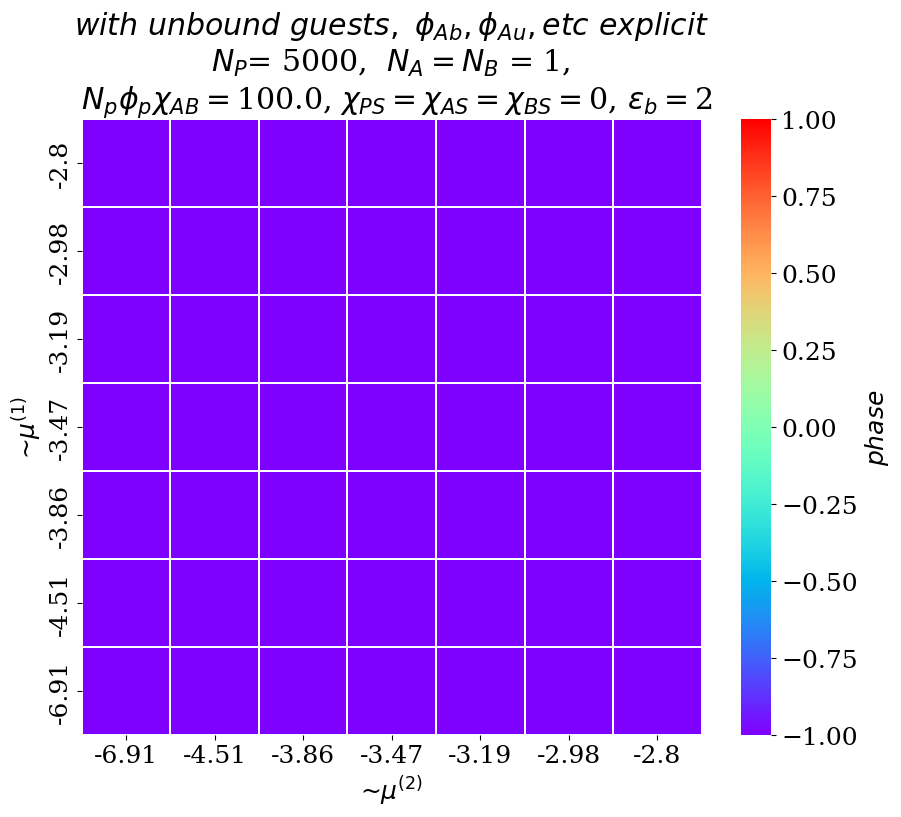

In [9]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ax = sns.heatmap(spinodal, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
                 cbar_kws={'label':  r"$phase$"}, vmin=-1, vmax=1)

spacing = 1
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("~$\mu^{(1)}$")
plt.xlabel("~$\mu^{(2)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$with \ unbound  \ guests, \ \phi_{Ab}, \phi_{Au}, etc \ explicit $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A  \
          +  "\n" +" $N_p \phi_p \chi_{AB} = $" + \
          str(np.round(chi_AB*N_P*phi_p,1)) +", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
         + ", $\epsilon_b = $" + str(e_m[0])) 

# plt.savefig('OABS_phases.png')

In [10]:
k_star_arr_DENS

array([[-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.]])

In [11]:
k_vec[0]

0.0031622776601683794

In [12]:
np.shape(sA_mat)

(7, 7, 50)

In [13]:
# np.save("testerrr", sA_mat+1)

In [14]:
# %%time

# mu1_i = 5
# mu2_i = 6
# mu1_array[mu1_i]
# chi = 0
# chis = [chi_AB, chi_AS]
# mu1_i_min = 5
# mu1_i_max = 15
# mu2_i_min = 5
# mu2_i_max = 15
# phases = np.zeros((len(mu1_array[mu1_i_min:mu1_i_max]), len(mu2_array[mu2_i_min:mu2_i_max]))) - 1 
# minF_arr = np.zeros((len(mu1_array[mu1_i_min:mu1_i_max]), len(mu2_array[mu2_i_min:mu2_i_max]))) 

# mu1_i = 0
# mu2_j = 6

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal
# k_star_arr_DENS[np.where(k_star_arr_DENS == k_vec[0]) ] = -1 # unphysical value, to indicate macrophase separation


phases = np.zeros((len(phi_Au_arr), len(phi_Bu_arr))) - 1 
minF_arr = np.zeros((len(phi_Au_arr), len(phi_Bu_arr))) 
for i, phi_Au in enumerate(phi_Au_arr):
    for j, phi_Bu in enumerate(phi_Bu_arr):
        # if i != mu1_i:
        #     continue
        # if j != mu2_j:
        #     continue

        # print("mu: ", mu1, mu2)
        q_star = k_star_arr_DENS[i,j]
        vec_star = min_eigvec_arr_allk_DENS[i,j]

        
        if q_star == -1:
            print("out of spinodal; no q_star")
            phases[i,j] = 0 # disordered phase- outside of spinodal
        elif q_star == k_vec[0]:
        # elif q_star != k_vec[-1]:
            print("macrophase sep")
            phases[i,j] = 1 # macrophase sep

        else: #microphse sep
        
            s_bnd_A = sA_mat[i,j,:]#s_bind_A_ALL[i,j,:]
            s_bnd_B = sB_mat[i,j,:]#s_bind_B_ALL[i,j,:]

            pihus = [phi_Au, phi_Bu]
            lam_q = q_star*np.array([1, 0, 0])
            lam_q = np.linalg.norm(lam_q)
    
            cyl_q1 = q_star*np.array([1, 0, 0])
            # cyl_q1 = np.linalg.norm(cyl_q1)
            cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
            # cyl_q2 = np.linalg.norm(cyl_q2)
            cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
            # cyl_q3 = np.linalg.norm(cyl_q3)
            cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
            
            bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
            bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
            bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
            bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
            bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
            bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
            
            
            lam_g3 = 0
            G3 = gamma3(psol, s_bnd_A, s_bnd_B, phius, cyl_qs) # all g3s are eqivlaent
            cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
            bcc_g3 = (4/(3*np.sqrt(6))) * G3
            
            G4_00 = gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([lam_q, -lam_q, lam_q, -lam_q]))
            lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
            
            cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
              72*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
            
            bcc_g4 = (1/24)* (G4_00 \
                     + 8*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
                     + 2*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
                     + 4*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
    
            lam_g2 = (1/2) * 2 * (1) * gamma2_chis(psol, s_bnd_A, s_bnd_B, phius, q_star)
            cyl_g2 = lam_g2
            bcc_g2 = lam_g2

            # # # PHYSICALLY BOUNDED AMPLITUDE
            # # del_phi = phi - phi_0. phi goes from 0 to phi_p. therefore del_phi(max) = phi_p-phi_0 ; del_phi(min) = - phi_0
            # # need to use a sigmoid (goes 0 to 1) then del_phi = phi_p * sigmoid(amps) - phi_0 ; phi_0 = [f_O, f_A, f_B]
            # # raise Exception("NNED to implement phi right----- look below :D")
            # phi_0 = phi_p * np.array([fo_mat[0][0], fa_mat[0][0], fb_mat[0][0]])
            # initial = [0, 0, 0] # poly, A, B
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                                 phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # lamF_q = res.fun
            
            # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    #  + np.einsum("ijk,i,j,k ->", cyl_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    # +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # cylF_q = 1000000000#res.fun

            # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    #  + np.einsum("ijk,i,j,k ->", bcc_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    # +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # bccF_q = 1000000000#res.fun          




            print("made it to crit fluc")            
            # CRITICAL FLUCTIATION
            # define a lambda scalar value for a given critica lfluctutaion, then use roots equation to find cirtical points, and eval F at each
            lam_lambda_2 = np.einsum("ij,i,j ->", lam_g2, vec_star, vec_star)
            lam_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -lam_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_l_amps = np.real(np.roots([4*lam_lambda_4,0,2*lam_lambda_2,0]))        
            lamF = min(np.real( lam_lambda_2 * pos_l_amps**2 + lam_lambda_4 * pos_l_amps**4))
    
            
            cyl_lambda_2 = np.einsum("ij,i,j ->", cyl_g2, vec_star, vec_star)
            cyl_lambda_3 = np.einsum("ijk,i,j,k->", cyl_g3, vec_star, vec_star, vec_star)
            cyl_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -cyl_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_c_amps = np.real(np.roots([4*cyl_lambda_4,3*cyl_lambda_3,2*cyl_lambda_2,0]))        
            cylF = min(np.real( cyl_lambda_2 * pos_c_amps**2 + cyl_lambda_3*pos_c_amps**3 + cyl_lambda_4 * pos_c_amps**4))
    
            
            bcc_lambda_2 = np.einsum("ij,i,j ->", bcc_g2, vec_star, vec_star)
            bcc_lambda_3 = np.einsum("ijk,i,j,k->", bcc_g3, vec_star, vec_star, vec_star)
            bcc_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -bcc_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_b_amps = np.real(np.roots([4*bcc_lambda_4,3*bcc_lambda_3,2*bcc_lambda_2,0]))        
            bccF = min(np.real( bcc_lambda_2 * pos_b_amps**2 + bcc_lambda_3*pos_b_amps**3 + bcc_lambda_4 * pos_b_amps**4))        


            

            # # # BASINHOPPING UNRESTRICTED works at low chi
        
            # initial = [0, 0, 0] # poly, A, B
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, amps, amps, amps, amps)), initial)
            # lamF_q = res.fun
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
            #                                     + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4, amps, amps, amps, amps)), initial)
            # cylF_q = res.fun
    
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
            #                                     + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4, amps, amps, amps, amps)), initial)
            # bccF_q = res.fun            


            
            minF = np.min([lamF, cylF, bccF, 0])
            minF_arr[i,j] = minF
            # print("--------------------------------------------------------------------")
            # print("energies:")
            print([lamF, cylF, bccF, 0])
            # print("--------------------------------------------------------------------")

            # # print([lamF])
            # # print([lamF, cylF])#, bccF])
            if minF == 0:
                # raise Exception("phase sep not stable in spinodal??")
                phases[i,j] = -2
            elif minF == lamF:
                phases[i,j] = 2
            elif minF == cylF:
                phases[i,j] = 3
            elif minF == bccF:
                phases[i,j] = 4

        np.save("expl_bind_minF_test_all_phases_SMALLBINDER_em="+str(e_m[0]), minF_arr)
        np.save("expl_bind_phases_test_all_phases_SMALLBINDER_em="+str(e_m[0]), phases)
            

out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
o

Text(0.5, 1.0, '$with \\ unbound  \\ guests, \\ \\phi_{Ab}, \\phi_{Au}, etc \\ explicit $\n$ N_P $= 5000,  $N_A = N_B$ = 50, \n $N_p \\phi_p \\chi_{AB} = $100.0, $\\chi_{PS} = \\chi_{AS} = \\chi_{BS} =$0, $\\epsilon_b = $2')

<Figure size 640x480 with 0 Axes>

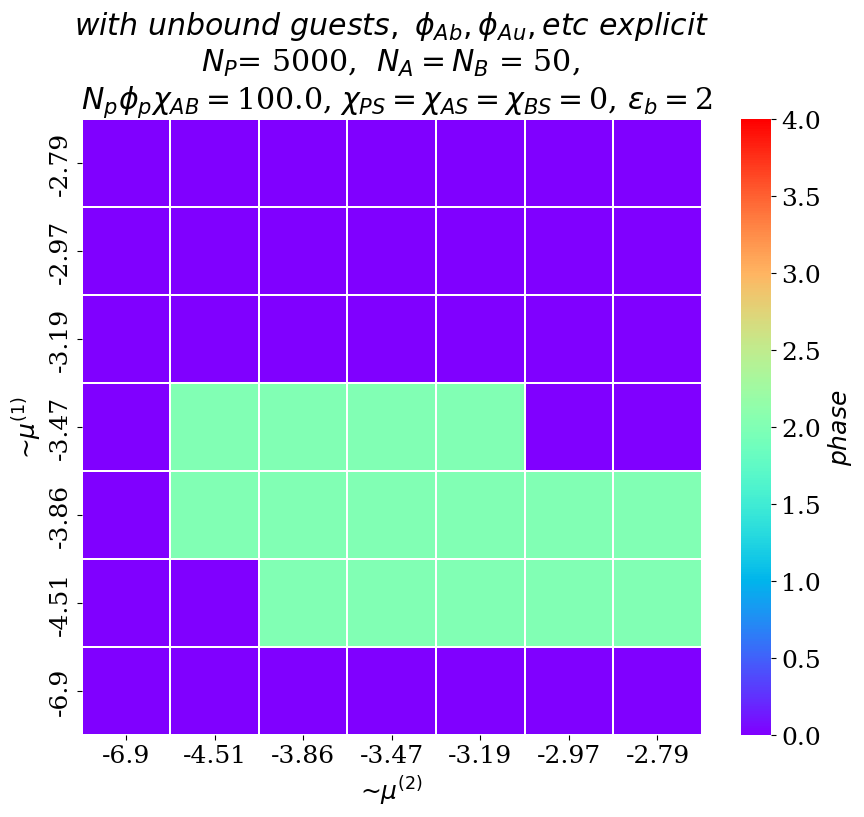

In [58]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ax = sns.heatmap(phases, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
                 cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=4)

spacing = 1
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("~$\mu^{(1)}$")
plt.xlabel("~$\mu^{(2)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$with \ unbound  \ guests, \ \phi_{Ab}, \phi_{Au}, etc \ explicit $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A  \
          +  "\n" +" $N_p \phi_p \chi_{AB} = $" + \
          str(np.round(chi_AB*N_P*phi_p,1)) +", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
         + ", $\epsilon_b = $" + str(e_m[0])) 

# plt.savefig('OABS_phases.png')

In [60]:
phases

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  2.,  2.,  2.,  2.],
       [ 0.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 0.,  2.,  2.,  2.,  2., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.]])

In [31]:
minF_arr

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -8.93829853e-22,
        -2.09051542e-22],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.28864161e-11, -1.93869215e-20,
        -1.47397423e-21],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -8.93830115e-22, -1.93869334e-20, -2.98944381e-11,
        -3.01202399e-20],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.09051584e-22, -1.47397469e-21, -3.01202583e-20,
        -2.7277274

In [7]:
# minF = np.load("expl_bind_minF_test_all_phases.npy")
# phases = np.load("expl_bind_phases_test_all_phases.npy")

In [9]:
# np.save("expl_bind_minF_test_all_phases_em=1.52", minF)
# np.save("expl_bind_phases_test_all_phases_em=1.52", phases)

In [31]:
# print("made it to crit fluc")            
# # CRITICAL FLUCTIATION
# # define a lambda scalar value for a given critica lfluctutaion, then use roots equation to find cirtical points, and eval F at each
# lam_lambda_2 = np.einsum("ij,i,j ->", lam_g2, vec_star, vec_star)
# lam_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -lam_g4, vec_star, vec_star, vec_star, vec_star)

# pos_l_amps = np.real(np.roots([4*lam_lambda_4,0,2*lam_lambda_2,0]))        
# lamF = min(np.real( lam_lambda_2 * pos_l_amps**2 + lam_lambda_4 * pos_l_amps**4))

In [32]:
# K1, K2, K3, K4 = np.array([lam_q, -lam_q, lam_q, -lam_q])
# if np.linalg.norm(K1+K2+K3+K4) >= 1e-10:
#     raise Exception('Qs must add up to zero')    
# K = np.linalg.norm(K1)
# K12 = np.linalg.norm(K1+K2)
# K13 = np.linalg.norm(K1+K3)
# K14 = np.linalg.norm(K1+K4)

# # [n_bind, v_int, Vol_int, e_m, rho_p, rho_s, poly_marks, M, mu_max, mu_min, del_mu, alpha, N, N_m, b] = chrom
# # N = psol.N
# corrs = [s_bnd_A, s_bnd_B]

# # s4 = calc_sf4(psol, corrs, phius, K1, K2, K3, K4) 
# s3_12 = calc_sf3(psol, corrs, phius, K1, K2, -K1-K2) #NANS
# s3_14 = calc_sf3(psol, corrs, phius, K1, K4, -K1-K4) #NANS
# s3_23 = calc_sf3(psol, corrs, phius, K2, K3, -K2-K3) #NANS
# s3_24 = calc_sf3(psol, corrs, phius, K2, K4, -K2-K4)
# s3_34 = calc_sf3(psol, corrs, phius, K3, K4, -K3-K4) #NANS
# s3_13 = calc_sf3(psol, corrs, phius, K1, K3, -K1-K3)


# S2_inv_red = sf2_inv_raw(psol, corrs, phius, K)
# S2_inv_red_12 = sf2_inv_raw(psol, corrs, phius, K12)
# S2_inv_red_13 = sf2_inv_raw(psol, corrs, phius, K13)
# S2_inv_red_14 = sf2_inv_raw(psol, corrs, phius, K14)

# S2_inv_red_2 = sf2_inv_raw(psol, corrs, phius, K2)
# S2_inv_red_3 = sf2_inv_raw(psol, corrs, phius, K3)
# S2_inv_red_4 = sf2_inv_raw(psol, corrs, phius, K4)

In [ ]:
#PRINT all sfs, see where nan comes from